In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, Dense, LSTM,Embedding
from tensorflow.keras.layers import LSTM,GRU
from joblib import dump, load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError


from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import pprint


%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [4]:
# hyper params
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# t -13 예측
SEQ_LEN = 14
# t + 1 예측
PRED_LEN = 1

BATCH_SIZE = 16
DROPOUT = 0.2
model_path = os.path.join(os.getcwd(), 'model')
data_path = os.path.join(os.getcwd(), 'data')
result_path = os.path.join(os.getcwd(), 'result')

try:
    os.makedirs(model_path)
    os.makedirs(result_path)    

except FileExistsError:
    pass

In [5]:
# 국제
dataset1 = pd.read_csv(os.path.join(data_path, "국제_원유가격.csv"), parse_dates=['기간'], encoding='utf-8')
dataset1 = dataset1.sort_values('기간')

# 국내
dataset2 = pd.read_csv(os.path.join(data_path, "주유소_평균판매가격.csv"), parse_dates=['구분'], encoding='utf-8')
dataset2 = dataset2.sort_values('구분')

In [69]:
total_dataset = pd.merge(left=dataset1, right=dataset2, left_on='기간', right_on='구분')
del total_dataset['구분']
total_dataset

df1 = total_dataset.loc[:,['Dubai', '고급휘발유']]

# scaling data
scaler1 = MinMaxScaler()
scaled_df1 = pd.DataFrame(scaler1.fit_transform(df1))

In [73]:
np.array(scaled_df1.iloc[i:i+window_size,:]).reshape(window_size ,2)

array([[0.72220475, 0.87731063],
       [0.72220475, 0.82402803],
       [0.72220475, 0.81650593],
       [0.71693663, 0.8151748 ],
       [0.73234785, 0.81420786],
       [0.74146878, 0.81429576],
       [0.74280547, 0.8258489 ],
       [0.70459192, 0.8394992 ],
       [0.70309797, 0.84168425],
       [0.7020758 , 0.84665712],
       [0.73226922, 0.85176813],
       [0.73226922, 0.85662799],
       [0.76552917, 0.86363522],
       [0.75695864, 0.86681234]])

In [74]:
window_size = 14

X = []
Y = []

for i in range(0 , len(scaled_df1) - window_size -1 , 1):
    X.append(np.array(scaled_df1.iloc[i:i+window_size,:]).reshape(window_size ,2))
    Y.append(np.array(scaled_df1.iloc[i+window_size,1]).reshape(1,1))

train_X,test_X,train_y,test_y = train_test_split(X, Y, test_size=0.05,shuffle=False)
len_t = len(train_X)

train_X = np.array(train_X)
test_X = np.array(test_X)
train_y = np.array(train_y)
test_y = np.array(test_y)

train_X = train_X.reshape(train_X.shape[0],2,14,1)
test_X = test_X.reshape(test_X.shape[0],2,14,1)

In [76]:
model = Sequential()
#add model layers
model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu', input_shape=(None,14,2))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(256, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(512, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200,return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
 
histroy = model.fit(train_X, train_y, validation_data=(test_X,test_y), epochs=20)

Epoch 1/20
108/108 [==============================] - 22s 72ms/step - loss: 0.0171 - val_loss: 0.0024
Epoch 2/20
108/108 [==============================] - 5s 45ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 3/20
108/108 [==============================] - 5s 43ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 4/20
108/108 [==============================] - 5s 44ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 5/20
108/108 [==============================] - 5s 43ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 6/20
108/108 [==============================] - 5s 44ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 7/20
108/108 [==============================] - 5s 44ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 8/20
108/108 [==============================] - 5s 43ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 9/20
108/108 [==============================] - 5s 45ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 10/20
108/108 [==============================] - 5s 44ms/step - loss: 0.0033 - val_l

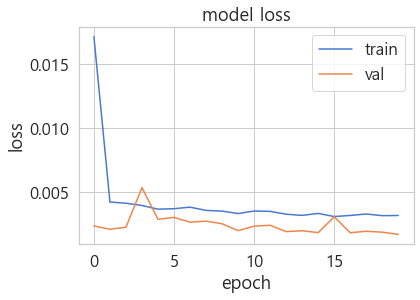

In [77]:
# Convergence of loss
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [78]:
print(model.summary())
print(model.evaluate(test_X,test_y))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeDi  (None, 2, 14, 128)       256       
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 2, 7, 128)        0         
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 2, 7, 256)        33024     
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 2, 3, 256)        0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 2, 3, 512)       

In [124]:
predicted  = model.predict(test_X)
predicted = np.array(predicted[:,0]).reshape(-1,1)

y_test_inverse = scaler1.inverse_transform(pd.DataFrame(
        {df1.columns[0]: test_y.reshape(-1), 
        df1.columns[1]: predicted.reshape(-1)}
        ))

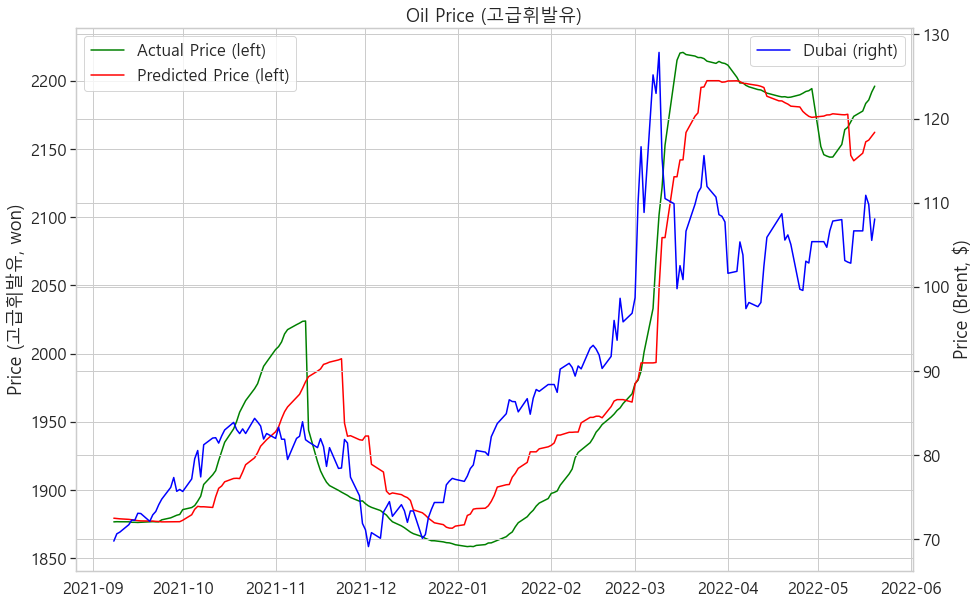

In [127]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.plot(total_dataset.iloc[-len(y_test_inverse):, 0], df1.iloc[-len(y_test_inverse):, 1], label="Actual Price (left)", color='green')
ax1.plot(total_dataset.iloc[-len(y_test_inverse):, 0], y_test_inverse[:, 1], label="Predicted Price (left)", color='red')
ax1.set_ylabel(f'Price ({df1.columns[1]}, won)')

ax2 = ax1.twinx()
ax2.plot(total_dataset.iloc[-len(y_test_inverse):, 0], df1.iloc[-len(y_test_inverse):, 0], label="Dubai (right)", color='blue')
ax2.set_ylabel(f'Price (Brent, $)')

plt.title(f'Oil Price ({df1.columns[1]})')
plt.xlabel('Time [days]')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()